# Notebook to Follow Experiment Tracking Lessons

In [1]:
!python -V

Python 3.9.16


In [5]:
from pathlib import Path
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [6]:
data_pth = Path('./data/')

In [7]:
df = pd.read_parquet(data_pth/'green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829626

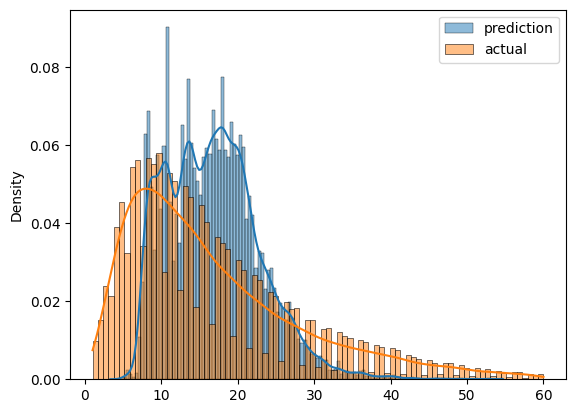

In [18]:
sns.histplot(y_pred, label='prediction', kde=True, stat='density', bins='auto')
sns.histplot(y_train, label='actual', kde=True, stat='density', bins='auto')

plt.legend()
plt.show()

In [19]:
# function to read dataframe
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [20]:
# read files as train and validation
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [21]:
len(df_train), len(df_val)

(73908, 61921)

In [22]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [23]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [24]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715206931833

In [26]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [27]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

# Experiment Tracking with MLflow

In [28]:
import mlflow 
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-experiment')

<Experiment: artifact_location='/Users/addingtongraham/github-repos/mlops/experiment-tracking/mlruns/1', creation_time=1683821980697, experiment_id='1', last_update_time=1683821980697, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [30]:
with mlflow.start_run():
    mlflow.set_tag('developer', 'kai')
    mlflow.log_param('train-data-path', data_pth/'green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path', data_pth/'green_tripdata_2021-02.parquet')
    
    alpha = 0.1
    mlflow.log_param('alpha',alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)
    mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')

## Hyperparameter Tuning with MLflow

Will use `hyperopt` for hyperparameter tuning:
- `fmin`: will minimize target output
- `hp`: library that contains different methods to define search space 
- `Trials`: will keep track of information from each run 
- `scope`: use it to define ranges

In [38]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope 
from hyperopt import space_eval 

In [37]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

`objective` function will start a run with mlflow.

In [33]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=200,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric('rmse',rmse)
    
    return {'loss': rmse,'status':STATUS_OK}

Now define search space -- ranges we want hyperopt to explore with xgboost.

`quniform`: returns real numbers (no decimals)

`loguniform`: drawing values using the listed distribution -- variable will be constrained to an interval
`tpe`: is the algorithm used to run the optimization with hyperopt

In [34]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # interval is [exp(-3), exp(0)], which is more or less [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()b
)

[12:44:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.73300                          
[1]	validation-rmse:12.19844                          
[2]	validation-rmse:9.95971                           
[3]	validation-rmse:8.57105                           
[4]	validation-rmse:7.75687                           
[5]	validation-rmse:7.28030                           
[6]	validation-rmse:6.99586                           
[7]	validation-rmse:6.81618                           
[8]	validation-rmse:6.71072                           
[9]	validation-rmse:6.63980                           
[10]	validation-rmse:6.59519                          
[11]	validation-rmse:6.56787                          
[12]	validation-rmse:6.55229                          
[13]	validation-rmse:6.53663                          
[14]	validation-

In [40]:
# get best params 
space_eval(search_space, best_result)

{'learning_rate': 0.5732408105763979,
 'max_depth': 22,
 'min_child_weight': 1.186456107449367,
 'objective': 'reg:linear',
 'reg_alpha': 0.041314794012194525,
 'reg_lambda': 0.07347301899254197,
 'seed': 42}

In [41]:
# train model using params we obtained
params = {
    'learning_rate': 0.5732408105763979,
    'max_depth': 22,
    'min_child_weight': 1.186456107449367,
    'objective': 'reg:linear',
    'reg_alpha': 0.041314794012194525,
    'reg_lambda': 0.07347301899254197,
    'seed': 42 
}

# some libraries allow autolog
mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=200,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2023/05/11 13:33:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '25ace346e0b347748811e061ec4ee427', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[13:33:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:11.42652
[1]	validation-rmse:8.07455
[2]	validation-rmse:7.06024
[3]	validation-rmse:6.74991
[4]	validation-rmse:6.63463
[5]	validation-rmse:6.58976
[6]	validation-rmse:6.57495
[7]	validation-rmse:6.56711
[8]	validation-rmse:6.55847
[9]	validation-rmse:6.55429
[10]	validation-rmse:6.54800
[11]	validation-rmse:6.54515
[12]	validation-rmse:6.53893
[13]	validation-rmse:6.53389
[14]	validation-rmse:6.52557
[15]	validation-rmse:6.51943
[16]	validation-rmse:6.51753
[17]	validation-rmse:6.51366
[18]	validation-rmse:6.50914
[19]	validation-rmse:6.50656
[20]	validation-rmse:6.50077
[21]	validation-rmse:6.49619
[22]	validation-rmse:6.49381
[23]	validation-rmse:6.49048
[24]	validation-rmse:6.48696
[25]	validation-rmse:6.48360
[26]	validation-rmse:6.48127
[27]	validat

2023/05/11 13:34:03 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2023/05/11 13:34:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/addingtongraham/mambaforge/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
